# A Simple Neural Network

Training a neural network happens in two steps:

**Forward Propagation**: In forward prop, the NN makes its best guess about the correct output. It runs the input data through each of its functions to make this guess.

**Backward Propagation**: In backprop, the NN adjusts its parameters proportionate to the error in its guess. It does this by traversing backwards from the output, collecting the *derivatives* of the error with respect to the parameters of the functions (gradients), and uses this gradient to adjust its internal values.

In the previous notebook we implemented the `Value` object, which is used to perform the backward propagation. In this notebook, we'll implement forward propagation from scratch. First for a single neuron, and then for a full neural network. We'll then combine forward and backward propagation to train a neural network on a real dataset.

In [1]:
# To allow importing modules from the nnfs directory, can be ignored
import sys
import os

# Get the absolute path of the 'src' directory
src_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add 'src' directory to the Python path
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
import random
import math

import numpy as np
import matplotlib.pyplot as plt

from nnfs.autograd import Value
from nnfs.helpers import (
    draw_dot, # Must first download graphviz at: https://graphviz.org/download/
    np_array_to_list_of_values, 
    list_of_values_to_np_array
)

np.random.seed(42)
random.seed(42)

%matplotlib inline

## The Neuron

An artificial neuron is a fundamental building block of dense neural networks. It's inspired by biological neurons in the human brain, but is a simplified, mathematical model. The artificial neuron is illustrated below:

![An artificial neuron](img/neuron_model.png)

Here's a basic breakdown:

1. **Inputs**: The artificial neuron receives one or more inputs $x_i$. These could be raw data points, like pixels from an image, or outputs from other neurons.
2. **Weights**: Each input $x_i$ has an associated weight $w_i$, which can be adjusted over using backprop. Think of these weights as dials or knobs that can be turned to make the neuron behave differently. Each neuron also has a bias $b$, which is a baseline constant that can also be adjusted.
4. **Summation**: The neuron multiplies each input $x_i$ by its weight $w_i$, then sums up all these products, and adds the bias $b$. Giving us the formula $\sum_{i=1}^{n} w_i x_i + b$.
4. **Activation Function**: This sum then passes through an activation function $f$. The purpose of this function is to introduce non-linearity to the model, which allows neural networks to learn complex patterns. Common activation functions include the sigmoid, ReLU, and tanh.
5. **Output**: The result from the activation function is the output of the neuron, which can then serve as an input to another neuron in the next layer of a neural network or as the final output of a neural network.

In essence, the artificial neuron takes in data, processes it using its weights and the activation function, and outputs the result.

#### Activation Function

In this notebook, we'll use the $\tanh$ as activation function for our neurons, which is defined as:

$$\tanh(x) = \frac{e^{2x} - 1}{e^{2x} + 1}$$

$\tanh$, is a mathematical function that squishes the input values to a s-curve with values in the range (-1, 1).
It is useful as an activation function because it smooth, differential, and non-linear with values centered around zero. These are 
all properties that are useful for neural networks.

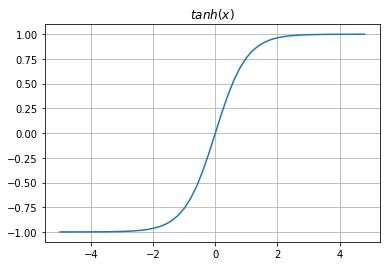

In [3]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()
plt.title('$tanh(x)$')
plt.show()

We'll now implement a neuron. It will take with two inputs of the type `Value` object we created last notebook and use $\tanh$ as an activation function. We will manually initialize its weights and bias. We'll later see how we can initialize them automatically when we generalizes the code below into a class.

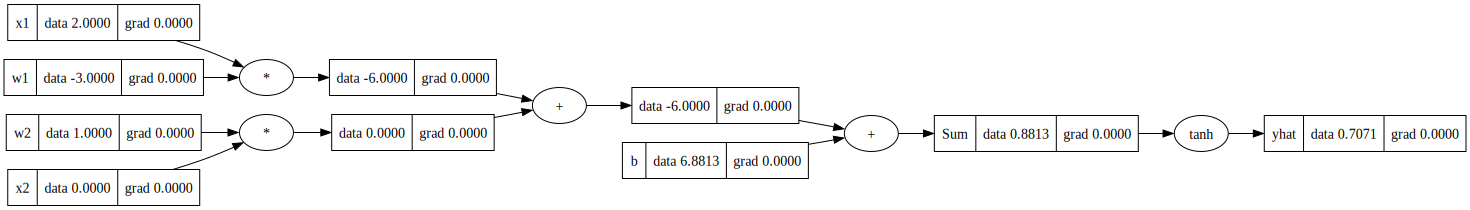

In [4]:
x = [Value(2.0, label='x1'), Value(0.0, label='x2')]  # inputs
w = [Value(-3.0, label='w1'), Value(1.0, label='w2')]  # weights
b = Value(6.8813, label='b')  # bias

# forward pass
f = x[0] * w[0] + x[1] * w[1] + b; f.label = 'Sum'  # Summation
yhat = f.tanh(); yhat.label = 'yhat'  # Activation function

draw_dot(yhat)

That was simple! All there is to a forward pass of a single neuron is: Multiply the inputs with weights, sum them up, add the bias, and pass the result through an activation function. 

We can now easily generalize this to a neuron that takes any number of inputs and outputs, and can use several different activation functions (including none). We'll also make the weights and bias automatically initialized to random values.

In [5]:
class Neuron:
  
    def __init__(self, num_inputs, activation='tanh'):
        """Initialize the weights and bias randomly, and set the activation function"""
        self.w = [Value(random.uniform(-1,1), label=f'w_{i+1}') for i in range(num_inputs)]
        self.b = Value(random.uniform(-1,1), label='b')
        self.activation = activation
  
    def __call__(self, x):
        """The forward pass of a single neuron"""
        # Check that the number of inputs equals the number of weights
        if len(x) != len(self.w):
            raise ValueError(f'Expected {len(self.w)} inputs, got {len(x)}')
        
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)  # sum(w * x) + b
        if self.activation == 'tanh':
            out = act.tanh()
        elif self.activation == 'relu': # The ReLU activation equals to max(0, x)
            out = act.relu()
        else:  # The output of the neuron stays linear
            out = act
        return out
  
    def parameters(self):  
        """Return the weights and bias as a list"""
        return self.w + [self.b]
    
    def zero_grad(self):
        """Reset the gradients to zero"""
        for p in self.parameters():
            p.grad = 0
    
    def __repr__(self):
        if self.activation == 'tanh':
            neuron_type = 'Tanh'
        elif self.activation == 'relu':
            neuron_type = 'ReLU'
        else:
            neuron_type = 'Linear'
        return f'{neuron_type}Neuron({len(self.w)})'

There is a reason we initialize the weights randomly. If all weights are initialized with the same value, every neuron in the hidden layer will produce the same output and thus undergo the same weight updates during training due to having the same gradient. This makes the neurons in that layer all symmetric and redundant. Random initialization ensures that each neuron starts with a different weight and thus follows a unique gradient during training.

### Using `Neuron` to do linear regression

A single `Neuron` is able to do standard linear regression if we do not use an activation function. We can illustrate this by generating a dataset with a linear relationsship between features and target, and then training a neuron on it.

We'll generate data using the relationsship $y=2 x_1+ 0.8x_2 + \epsilon$, where $x_i$ are the inputs, $\epsilon$ is a random noise term, and $y$ is the target.

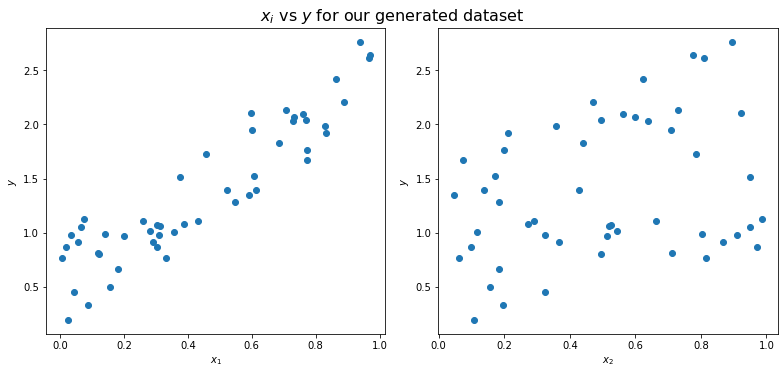

In [6]:
x = np.random.random((50, 2))
eps = np.random.random((50, )) * 0.2
y = 2 * x[:, 0] + 0.8 * x[:, 1] + eps

fig, axs = plt.subplots(1, 2, figsize=(11, 5))

axs[0].scatter(x[:,0], y, label='x1')
axs[0].set_xlabel('$x_1$')
axs[0].set_ylabel('$y$')

axs[1].scatter(x[:,1], y, label='x2')
axs[1].set_xlabel('$x_2$')
axs[1].set_ylabel('$y$')

fig.tight_layout()
fig.suptitle('$x_i$ vs $y$ for our generated dataset', y=1.03, fontsize=16)
plt.show()

To properly train our model we need a score to measure how well the model is doing. The goal of the model is to minimize this score during training. The score is called the loss (or cost) function in ML literature. In our linear regression example, we'll minimize the mean squared error (MSE), which is the most commonly used loss function for regression problems. The MSE is defined as
the average of the squared difference between the predicted and actual values. Or in mathematical notation:

$$MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

where $n$ is the number of samples, $y_i$ is the actual value, and $\hat{y}_i$ is the predicted value.

We'll start with minimizing the MSE for one iteration and for one sample to see to that everything works as expected. We'll then extend training to all samples in the dataset over multiple iterations to properly fit our model.

In [7]:
def mse(y_true, y_pred):
    # Convert inputs to lists of values if they are scalars
    if not hasattr(y_true, '__iter__'):
        y_true = [y_true]
    if not hasattr(y_pred, '__iter__'):
        y_pred = [y_pred]
        
    num_items = len(y_true)
    return sum((y_i - pred_i)**2 for y_i, pred_i in zip(y_true, y_pred)) / num_items


linear_model = Neuron(num_inputs=2, activation='linear')  # num_inputs = number of features
linear_model

LinearNeuron(2)

We're now ready to do the forward pass:

In [8]:
# Forward pass
output = linear_model(x[0])
loss = mse(y[0], output)
loss

Value(7.6430, grad=0.0000)

The next step is to do the backwards pass. We have already implemented the backwards pass in the `Value` class we created the last notebook. We can do backward-propagation by calling the `.backward()` method on the `loss` value. `loss.backward()` will compute the derivatives of the loss with respect to the inputs used to produce it, including the neuron weights.

The derivatives shows how the loss will respond if we change the weights a tiny nudge. We can use this fact to adjust the weights in the direction that reduces the loss. The illustration below demonstrates this:

![Gradient Descent](img/gradient_descent.png)

In the image above, the current position is the loss of the model with the current weights. The derivative of the loss function with repsect to the weight gives slope of the loss function at the current position. Knowing the direction of the slope, we can nudge the weights in the direction downwards so that the loss is reduced. Doing this iteratively will move the weights closer and closer to the bottom of the loss function, which is the point where the loss is minimized.

It should be noted that not all problems and loss functions have this smooth bowl shape. Most problems are much more complex and have many hills and valleys. An ever-changing landscape means that we can't just take a single huge step in the direction of the current slope to get to the bottom. We need to take many smaller steps and each time find the slope at the new location to reach the bottom of the loss function landscape. We can't know the slope of a point we haven't reached yet!

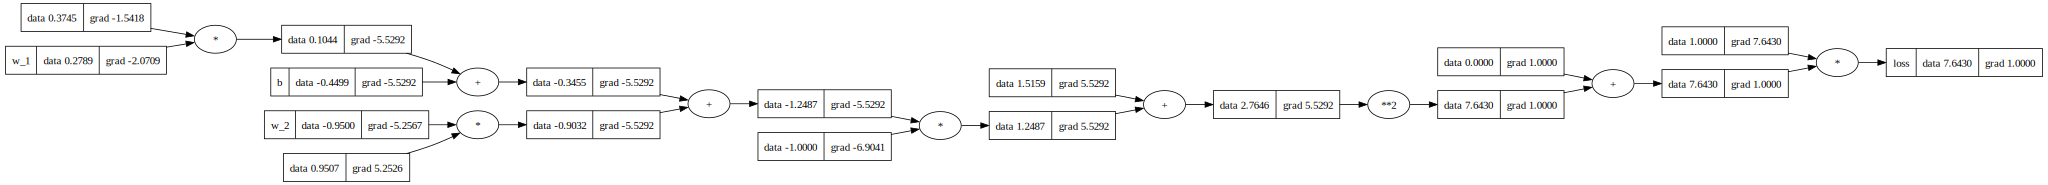

In [9]:
# Backward pass
loss.backward(); loss.label = 'loss'
draw_dot(loss)

Now, there is just the last step left: updating the weights in the direction that lowers the loss.

But what direction do we have to travel to decrease the loss? Let's think this through. We can see that the gradients for the weights are $\frac{d_{loss}}{dw_1}=-2.07$, $\frac{d_{loss}}{dw_2}=-5.26$, and $\frac{d_{loss}}{db}=-5.53$, while $loss=7.64$. All three gradients are negative, which means that the loss will decrease if we increase the weights. So moving the weights in the positive direction when the gradients are negative will decrease the loss. We can also reason about the opposite case: if the gradients are positive, then increasing the weights would increase the loss, which is the opposite of what we want. So we need to move the weights in the negative direction to decrease the loss if the gradients are positive. This gives us the general rule: *move the weights in the opposite direction of the gradients to decrease the loss*.

In [10]:
def update_weights(neuron, learning_rate=0.01):
    for parameter in neuron.parameters():
        parameter.data -= parameter.grad * learning_rate
    neuron.zero_grad()  # Reset the gradients to zero
    return neuron

Notice the parameter `learning_rate` in the code above. `learning_rate` is a parameter that controls the size of the step we take when updating the weights. It must often be fine-tuned to get the best results out of the training. Too small of a learning rate will result in slow training, while too large of a learning rate will result in the model overshooting the optimal weights and never converging.

![learning_rate](img/learning_rate.jpg)

In [11]:
# Weights before and after update
print(linear_model.w, linear_model.b)
linear_model = update_weights(linear_model, learning_rate=0.01)
print(linear_model.w, linear_model.b)

[Value(0.2789, grad=-2.0709, label=w_1), Value(-0.9500, grad=-5.2567, label=w_2)] Value(-0.4499, grad=-5.5292, label=b)
[Value(0.2996, grad=0.0000, label=w_1), Value(-0.8974, grad=0.0000, label=w_2)] Value(-0.3946, grad=0.0000, label=b)


Now, let's check if the loss has decreased after one iteration.

In [12]:
output = linear_model(x[0])
loss = mse(y[0], output)
loss  # Previous loss = 7.6430

Value(7.0308, grad=0.0000)

Success! We've moved the weights in a direction that lowers the loss. 

We can now extend this training proccess to train on all samples in the dataset and to train over multiple iterations so we can fit our linear model properly to the data.

In [13]:
def train_model(model, num_iterations, learning_rate):
    # Trains the model with gradient descent
    for i in range(num_iterations):
        # Forward Pass
        outputs = (model(xi) for xi in x)
        loss = mse(y, outputs)
        # Backward Pass
        loss.backward()
        # Update
        update_weights(model, learning_rate=learning_rate)
        print(f'{i}: {loss.data:.4f}')

linear_model = Neuron(num_inputs=2, activation='linear')  # reset the weights
train_model(linear_model, num_iterations=100, learning_rate=0.5)

0: 1.6482
1: 0.6424
2: 0.3794
3: 0.2864
4: 0.2365
5: 0.2006
6: 0.1717
7: 0.1476
8: 0.1272
9: 0.1099
10: 0.0952
11: 0.0826
12: 0.0720
13: 0.0628
14: 0.0550
15: 0.0482
16: 0.0425
17: 0.0375
18: 0.0332
19: 0.0295
20: 0.0262
21: 0.0234
22: 0.0210
23: 0.0189
24: 0.0170
25: 0.0154
26: 0.0140
27: 0.0128
28: 0.0117
29: 0.0107
30: 0.0099
31: 0.0091
32: 0.0085
33: 0.0079
34: 0.0074
35: 0.0069
36: 0.0065
37: 0.0062
38: 0.0059
39: 0.0056
40: 0.0054
41: 0.0051
42: 0.0049
43: 0.0048
44: 0.0046
45: 0.0045
46: 0.0044
47: 0.0043
48: 0.0042
49: 0.0041
50: 0.0040
51: 0.0039
52: 0.0039
53: 0.0038
54: 0.0038
55: 0.0037
56: 0.0037
57: 0.0036
58: 0.0036
59: 0.0036
60: 0.0036
61: 0.0035
62: 0.0035
63: 0.0035
64: 0.0035
65: 0.0035
66: 0.0035
67: 0.0034
68: 0.0034
69: 0.0034
70: 0.0034
71: 0.0034
72: 0.0034
73: 0.0034
74: 0.0034
75: 0.0034
76: 0.0034
77: 0.0034
78: 0.0034
79: 0.0034
80: 0.0034
81: 0.0034
82: 0.0034
83: 0.0034
84: 0.0034
85: 0.0034
86: 0.0034
87: 0.0034
88: 0.0034
89: 0.0034
90: 0.0034
91: 0.003

The proccess of iteratively moving the weights to reduce the loss is called gradient descent. The whole proccess of training a model with gradient descent can be summarized as follows:

1. Predict the output given the input data and current weights.
2. Compute the loss between the predicted and actual values.
3. Compute the gradient of the loss with respect to the weights.
4. Move the weights a small step in the direction opposite to the gradient to reduce the loss.

In [14]:
linear_model.parameters()

[Value(2.0056, grad=0.0000, label=w_1),
 Value(0.8337, grad=0.0000, label=w_2),
 Value(0.0766, grad=0.0000, label=b)]

We've successfully trained our neuron to fit the data. It predicts the relationship to be $\hat{y}=2.0056x_1+0.8337x_2+0.0766+\epsilon$, which is pretty close to the true relationship $y=2x_1+0.8x_2+\epsilon$.

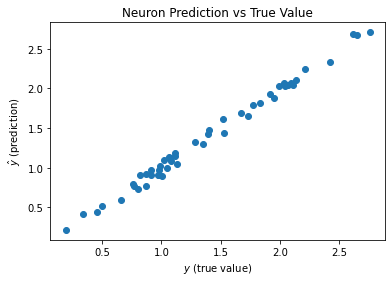

In [15]:
y_pred = [linear_model(xi).data for xi in x]

# plot scatter of y vs y_pred
plt.scatter(y, y_pred)
plt.xlabel('$y$ (true value)')
plt.ylabel('$\hat{y}$ (prediction)')
plt.title('Neuron Prediction vs True Value')
plt.show()

We can now move on to connecting together multiple neurons together to form a neural network.

## Neural Network

A neural network is a collection of artificial neurons, grouped into layers. 
Within each layer, neurons operate independently as they are not interconnected. However, each neuron connects to every other neuron in the layer before and after. You can see an illustration of a neural network below.

![A neural network](img/neural_network.jpg)

Here's a basic breakdown:

- **Input Layer**: The first "layer" of the network is the raw input data, and not artificial neurons. The number of items in this layer is the number of input features.
- **Hidden Layers**: After the input layer, we have the "hidden" layer(s). These layers take the output of the previous layer, processes and transforms it using artificial neurons. We can stack many of these layers where the output of the neurons one layer is the input of the neurons in the next layer. Each neuron in this layer is connected to every neuron in the previous and next layer.
- **Output Layer**: This is the final layer, which produces the result. The activation function used in the output layer differs from the hidden layers and depends on the task at hand. For example, in a binary classification task, the output layer might have a [sigmoid activation function](https://en.wikipedia.org/wiki/Logistic_function) which squishes the output between 0 and 1 to represent the probability of belonging to the positive class.
- **Weights**: Each connection between neurons has a weight, which determines the strength of the connection. During training, the weights are adjusted to optimize the network's performance using backpropagation.

The depth and non-linearity of a neural network allows it to learn very complex patterns in the data, making them very versatile and powerful. Neural Networks are used in applications like computer vision, natural language processing, speech recognition, time series forecasting, recommender systems, search engines, etc. 

As with the neuron, we'll first implement a hard-coded neural network before generalizing.

 We'll create the network which was illustrated above. It consists of an input layer with three features, two hidden layers with four neurons each, and an output layer with a single neuron. We'll use the $\tanh$ activation function for the hidden layers. We will pretend that we're doing a regression task so we'll use a linear activation function for the output layer.

In [16]:
x = [Value(2.0, label='x_1'), Value(0.0, label='x_2'), Value(-3.0, label='x_3')]  # inputs
y = [Value(1.0, label='y')]  # outputs

hidden_layer1 = [Neuron(3), Neuron(3), Neuron(3), Neuron(3)]  # Uses tanh activation by default
hidden_layer2 = [Neuron(4), Neuron(4), Neuron(4), Neuron(4)]
output_layer = Neuron(4, activation='linear')

The procedure for training a network is very similar to that of a single neuron. We'll use the same MSE loss function and gradient descent algorithm as before. Remember that the proccess of training a model is as follows: 

1. Predict the output given the input data and current weights.
2. Compute the loss between the predicted and actual values.
3. Compute the gradient of the loss with respect to the weights.
4. Move the weights a small step in the direction opposite to the gradient to reduce the loss.

We start with the forward pass of the network. It is done by passing the outputs of one layer to the next, until we reach the last layer which gives us the output of the network.

In [17]:
# Forward pass

# First hidden layer
a_1 = [neuron(x) for neuron in hidden_layer1]
# Second hidden layer
a_2 = [neuron(a_1) for neuron in hidden_layer2]  # The input is the output of the first hidden layer
# Output layer
yhat = output_layer(a_2)  # The input is the output of the second hidden layer
yhat

Value(-1.3343, grad=0.0000)

In [18]:
loss = mse(y, yhat)
loss

Value(5.4491, grad=0.0000)

As with the single neuron, the backward pass is as simple ass calling `.backward()` on the loss value to compute the gradients of the model.

In [19]:
# backward pass
loss.backward()

The last step is to update our weights using the gradients from the previous step.

In [20]:
# Updating the parameters
def update_weights(model, learning_rate=0.01):  # Redefined here for your convenience
    for parameter in model.parameters():
        parameter.data -= parameter.grad * learning_rate
    model.zero_grad()  # Reset the gradients to zero

LR = 0.01

update_weights(output_layer, LR)
for neuron in hidden_layer2:
    update_weights(neuron, LR)
for neuron in hidden_layer1:
    update_weights(neuron, LR)

We can now check that the proccess works by redoing the forward pass to see if the loss is reduced.

In [21]:
# Forward pass
a_1 = [neuron(x) for neuron in hidden_layer1]
a_2 = [neuron(a_1) for neuron in hidden_layer2]
yhat = output_layer(a_2)
loss = mse(y, yhat)
print(loss)  # Previous loss = 5.4491

Value(4.1383, grad=0.0000)


The neural network reduces its loss as expected. We now move on to generalizing what we just did. We'll do this by creating two new classes `Layer` and `VanillaNN`. We'll start with `Layer`.

The `Layer` class is simple. It is just a list of neurons, the number of which is defined by `num_ouputs`, each taking
`num_inputs` of features as inputs. The rest of the interface is the same as in `Neuron`.

In [22]:
class Layer:
    def __init__(self, num_inputs, num_outputs, activation='tanh'):
        self.neurons = [Neuron(num_inputs, activation) for _ in range(num_outputs)]

    def __call__(self, x):
        """The forward pass of a single layer"""
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        """Return the weights and bias of the whole layer as a list"""
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer({self.neurons})"
    
    def zero_grad(self):
        """Reset the gradients to zero"""
        for p in self.parameters():
            p.grad = 0

layer = Layer(3, 4, activation='relu')
print(layer)

Layer([ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3)])


`VanillaNN` is also just as simple. It is just a list of `Layer`s which implements its forward pass by passing the output of one layer as the input to the next.

In [23]:
class VanillaNN:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        """The forward pass of a full network"""
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        """Return the weights and bias of the whole network as a list"""
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        layers_str = ',\n  '.join([str(layer) for layer in self.layers])
        return f"VanillaNN([\n  {layers_str}\n])"

    def zero_grad(self):
        """Reset the gradients to zero"""
        for p in self.parameters():
            p.grad = 0

layers = [
    Layer(3, 4, activation='tanh'),
    Layer(4, 4, activation='tanh'),
    Layer(4, 1, activation='linear')
]
nn = VanillaNN(layers)
nn

VanillaNN([
  Layer([TanhNeuron(3), TanhNeuron(3), TanhNeuron(3), TanhNeuron(3)]),
  Layer([TanhNeuron(4), TanhNeuron(4), TanhNeuron(4), TanhNeuron(4)]),
  Layer([LinearNeuron(4)])
])

The simplicity of `Layer` and `VanillaNN` testifies to how much of the real work is already implemented by `Value` and `Neuron`.

We can do a sanity check of our network by implementing a training loop on the same data used above.

In [24]:
print(f'Actual Value: {y[0].data}')
print(f'Prediction before training: {nn(x).data:.4f}\n')
for _ in range(5):
    yhat = nn(x)
    loss = mse(y, yhat)
    print(f'{loss.data=:0.4f}')
    loss.backward()
    update_weights(nn, learning_rate=0.05)
    
print(f'\nPrediction after training: {nn(x).data:.4f}')

Actual Value: 1.0
Prediction before training: 0.5425

loss.data=0.2093
loss.data=0.0335
loss.data=0.0051
loss.data=0.0008
loss.data=0.0001

Prediction after training: 0.9959


Now, training on a fake "dataset" consisting of one single datapoint isn't exactly interesting, realistic, nor really in the spirit of deep learning. So let's train a neural network on something more akin to a real dataset.

## Training on a real dataset

The IRIS dataset is one of the most popular datasets in the world of machine learning and data science. It contains 150 observations of iris flowers from three different species. Each observation is described by four features:

1. Sepal Length
2. Sepal Width
3. Petal Length
4. Petal Width

The three species are:

1. Setosa
2. Versicolour
3. Virginica

Our goal is to predict the iris species based on its features. Let's start by loading and exploring the dataset.

In [25]:
import pandas as pd

iris = pd.read_csv('../data/IRIS.csv')
iris = iris.sample(frac=1, random_state=42)
iris['species'] = iris['species'].astype('category')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
73,6.1,2.8,4.7,1.2,Iris-versicolor
18,5.7,3.8,1.7,0.3,Iris-setosa
118,7.7,2.6,6.9,2.3,Iris-virginica
78,6.0,2.9,4.5,1.5,Iris-versicolor
76,6.8,2.8,4.8,1.4,Iris-versicolor


In [26]:
iris.species.value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: species, dtype: int64

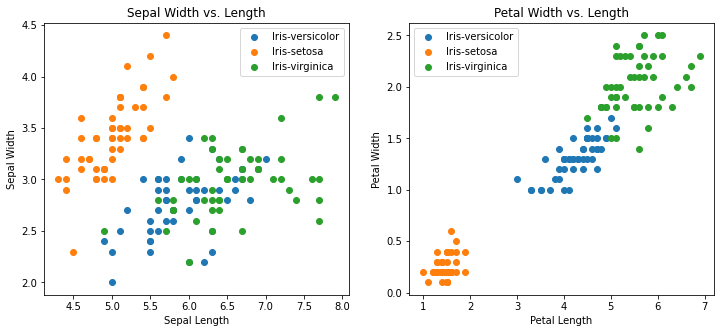

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Sepal width vs. length
for species in iris['species'].unique():
    subset = iris[iris['species'] == species]
    ax[0].scatter(subset['sepal_length'], subset['sepal_width'], label=species)
ax[0].set_title('Sepal Width vs. Length')
ax[0].set_xlabel('Sepal Length')
ax[0].set_ylabel('Sepal Width')
ax[0].legend()

# Petal width vs. length
for species in iris['species'].unique():
    subset = iris[iris['species'] == species]
    ax[1].scatter(subset['petal_length'], subset['petal_width'], label=species)
ax[1].set_title('Petal Width vs. Length')
ax[1].set_xlabel('Petal Length')
ax[1].set_ylabel('Petal Width')
ax[1].legend()

plt.show()

Next up is splitting the data into features and labels. For simplicity, we will only use petal length and petal width as features, so we can later visualize the decision boundaries in 2D. 

We'll also need to one-hot encode the labels so that we can use them in our network. One-hot encoding is a way to represent categorical data as binary vectors. For example, the label `Iris-setosa` will be represented as `[1, 0, 0]`, `Iris-versicolour` as `[0, 1, 0]`, and `Iris-virginica` as `[0, 0, 1]`. This is necessary because we can't use categorical data directly in our network. We need to represent them as numbers, and standard integer encoding would imply an order to the labels, which is not the case here.

In [28]:
# Features
x = iris[['petal_length', 'petal_width']]
x = np_array_to_list_of_values(x.values)

# Targets: one-hot encoded
y = pd.get_dummies(iris['species'])
idx_to_label = {i: label for i, label in enumerate(y.columns)}
y = np_array_to_list_of_values(y.values)

x[0], y[0]

([Value(4.7000, grad=0.0000), Value(1.2000, grad=0.0000)],
 [Value(0.0000, grad=0.0000),
  Value(1.0000, grad=0.0000),
  Value(0.0000, grad=0.0000)])

We're now ready to define our network. We'll use two hidden layers, the first with 12 neurons, the second with 6 neurons. The output layer will consists of three neurons, one for each class. We'll use the $\tanh$ activation function for the hidden layers and the softmax activation function for the output layer. 

*The softmax function* squishes the output of each neuron between 0 and 1 (much like $tanh$ squishes it between -1 and 1) and normalizes them so that the sum of all outputs is 1. This allows us to interpret the output as probabilities of belonging to each class. For example, if the output is `[0.1, 0.3, 0.6]`, we can interpret this as a 10% probability of belonging to the first class, 30% to the second class, and 60% to the third class.

The softmax activation function is defined as:

$$\sigma(z)_j = \frac{e^{z_j}}{\sum_{k=1}^{K}e^{z_k}}$$

where $z_j$ is the output of the $j$'th neuron and $K$ is the total number of neurons in the output layer. 

In [29]:
nn = VanillaNN([
    Layer(2, 12, activation='tanh'),
    Layer(12, 6, activation='tanh'),
    Layer(6, 3, activation='linear')
])
print(nn)
print(f'Number of parameters: {len(nn.parameters())}')

VanillaNN([
  Layer([TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2), TanhNeuron(2)]),
  Layer([TanhNeuron(12), TanhNeuron(12), TanhNeuron(12), TanhNeuron(12), TanhNeuron(12), TanhNeuron(12)]),
  Layer([LinearNeuron(6), LinearNeuron(6), LinearNeuron(6)])
])
Number of parameters: 135


In [30]:
def softmax(output):
    exp = [i.exp() for i in output]
    exp_sum = sum(exp)
    return [i / exp_sum for i in exp]

We'll use the cross-entropy as the loss function. The cross-entropy loss function is commonly used for classification problems. It is minimized when the predicted value of the correct class is 1 and the predicted value of all other classes is 0. For a single sample, it is defined as:

$$H(y, \hat{y}) = -\sum_{i=1}^{n}y_i\log(\hat{y}_i)$$

where $n$ is the number of classes, $y_i$ is the actual value of the $i$'th class, and $\hat{y}_i$ is the predicted value of the $i$'th class.

For multiple samples, it is defined as the average of the cross-entropy loss for each sample, or $\frac{1}{N}\sum_{j=1}^{N}H(y_j, \hat{y}_j)$, where $N$ is the number of samples.

In [31]:
def cross_entropy(y_true, y_pred):
    """The average cross entropy for multiple samples"""
    # Convert inputs to lists of values if they are scalars
    if not hasattr(y_true, '__iter__'):
        y_true = [y_true]
    if not hasattr(y_pred, '__iter__'):
        y_pred = [y_pred]

    # Add small value to output avoid log(0)
    EPSILON = 1e-15 
    y_pred = [[y_ij + EPSILON for y_ij in y_i] for y_i in y_pred]
    
    num_items = len(y_true)
    loss = 0.0
    for y, pred in zip(y_true, y_pred):
        loss += -sum([y_ij * pred_ij.log() for y_ij, pred_ij in zip(y, pred)])
    return loss / num_items

The last thing we need to do before training is to define a function to calculate the accuracy of the model. Which we will be used to monitor the performance of the model during training. Accuracy is simply defined as the number of correctly classified samples divided by the total number of samples.

In [32]:
def accuracy(y_true, y_pred):
    # Convert inputs to lists of values if they are scalars
    if not hasattr(y_true, '__iter__'):
        y_true = [y_true]
    if not hasattr(y_pred, '__iter__'):
        y_pred = [y_pred]

    # Convert one-hot encoded vectors to integers
    y_pred = [argmax(pred) for pred in y_pred]
    y_true = [argmax(y) for y in y_true]

    num_items = len(y_true)
    num_correct = sum((y_i == pred_i) for y_i, pred_i in zip(y_true, y_pred))
    return num_correct / num_items


def argmax(output):
    output = [o.data for o in output]
    return max(enumerate(output), key=lambda x: x[1])[0]

With all this in place, we're finally ready to train our model. 

In [33]:
LEARNING_RATE = 0.15
NUM_EPOCHS = 25

for epoch in range(1, NUM_EPOCHS+1):
    # Forward pass
    outputs = (nn(xi) for xi in x)
    yhat = [softmax(output) for output in outputs]
    loss = cross_entropy(y, yhat)
    acc = accuracy(y, yhat)
    print(f'{epoch=}: {loss.data:.4f}, {acc:.4f}')
    
    # Backward pass
    nn.zero_grad()
    loss.backward()
    
    # Update
    update_weights(nn, LEARNING_RATE)

epoch=1: 0.9315, 0.3400
epoch=2: 0.8437, 0.4600
epoch=3: 0.7853, 0.6867
epoch=4: 0.7382, 0.7067
epoch=5: 0.6986, 0.7067
epoch=6: 0.6646, 0.7133
epoch=7: 0.6349, 0.7333
epoch=8: 0.6087, 0.7333
epoch=9: 0.5854, 0.7467
epoch=10: 0.5645, 0.7600
epoch=11: 0.5455, 0.8000
epoch=12: 0.5283, 0.8333
epoch=13: 0.5125, 0.8533
epoch=14: 0.4981, 0.8600
epoch=15: 0.4849, 0.8733
epoch=16: 0.4728, 0.8733
epoch=17: 0.4617, 0.8933
epoch=18: 0.4513, 0.9067
epoch=19: 0.4417, 0.9067
epoch=20: 0.4326, 0.9067
epoch=21: 0.4241, 0.9467
epoch=22: 0.4160, 0.9467
epoch=23: 0.4083, 0.9533
epoch=24: 0.4009, 0.9533
epoch=25: 0.3938, 0.9667


We got 96.67% accuracy by training our model for 25 epochs. Not bad! We can plot the decision boundaries to get some sense of how the model is making predictions. The code for producing and plotting the decision boundaries is not important to understand, so it will not be explained.

In [34]:
def predict(x):
    outputs = (nn(xi) for xi in x)
    yhat = [softmax(output) for output in outputs]
    pred = [argmax(pred) for pred in yhat]
    return pred

In [35]:
# Create a meshgrid for the decision boundaries
x_min, x_max = iris['petal_length'].min() - 1, iris['petal_length'].max() + 1
y_min, y_max = iris['petal_width'].min() - 1, iris['petal_width'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                     np.arange(y_min, y_max, 0.05))
features = np.c_[xx.ravel(), yy.ravel()]  # Flatten the meshgrid

# Predict the class for each point in the meshgrid
preds = predict(features)

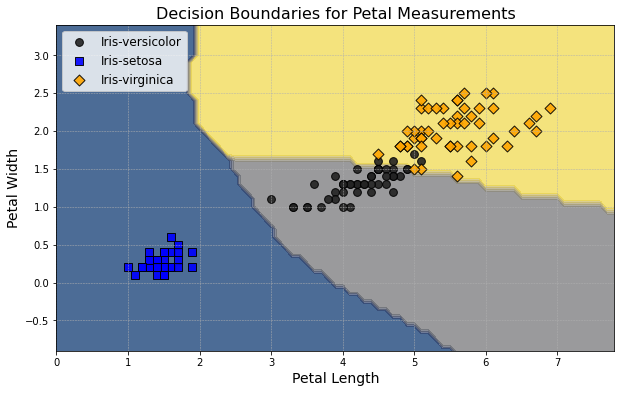

In [36]:
plt.figure(figsize=(10, 6))
zz = np.array(preds).reshape(xx.shape)
plt.contourf(xx, yy, zz, alpha=0.7, cmap=plt.cm.cividis)

colors = ['#222222', 'blue', 'orange']
markers = ['o', 's', 'D']

for i, species in enumerate(iris['species'].unique()):
    subset = iris[iris['species'] == species]
    plt.scatter(subset['petal_length'], subset['petal_width'], color=colors[i], 
                label=species, edgecolor='k', s=60, marker=markers[i], alpha=0.9)

# Aesthetic improvements
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Petal Length', fontsize=14)
plt.ylabel('Petal Width', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.title('Decision Boundaries for Petal Measurements', fontsize=16)
plt.show()


The plot shows that our model is capable to fit a non-linear decision boundary. This is because of the non-linear activation function we used in the hidden layers. If we used a linear activation function, the decision boundary would be linear as well.

## Conclusion

Well, there you have it. A neural network from scratch using only pure Python. Let's recap what we did:

1. **Back-propagation**: We implemented the `Value` object, which stores the expression graph that created it and is able compute the derivative of its output with respect to its inputs all the way through this graph. 
2. **Neuron**: We implemented the `Neuron` object, which implements the forward pass of a single neuron. The forward pass of a neuron takes a specified number of inputs, multiplies them with weights, sums them up, adds a bias, and passes them through an activation function to produce an output. 
3. **Implementing our First Training Loop**: We trained the neuron to do linear regression on a simple dataset to verify that it works correctly, introducing concepts such as loss functions, gradient descent, and learning rate in the proccess.
4. **Neural Network**: We implemented the `Layer` and `VanillaNN` objects, which implement the forward pass of a layer and a neural network, respectively.
5. **Iris**: Lastly, We trained the network to classify the Iris dataset, introducing concepts such as softmax, cross-entropy, and accuracy.

We've only scratched the surface of neural networks. There are many more architectures, many of them more complex (and more used) than the one we implemented here. We will explore some of them in future notebooks.